<a href="https://colab.research.google.com/github/meltonme/Time-Series-Analysis/blob/main/SARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://pypi.org/project/pmdarima/

#dependencies
!pip install yahooquery
from yahooquery import Ticker
import pandas as pd
import matplotlib.pyplot as plt
!pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Suppress FutureWarning
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.0 MB/s eta 0:00:00


In [ ]:
# Define the ticker symbol
ticker_symbol = 'SPOT'  # Example for Spotify Technologies

# Create a Ticker object
ticker = Ticker(ticker_symbol)

# Get historical data (e.g., 1 year of daily data)
historical_data = ticker.history(period='1y', interval='1d')

In [ ]:
# Reset index and prepare data
historical_data.reset_index(inplace=True)
historical_data['date'] = pd.to_datetime(historical_data['date']).dt.date
historical_data.set_index('date', inplace=True)
historical_data.sort_index(inplace=True)
historical_data = historical_data.fillna(method='ffill')

In [ ]:
# Extract time series
y = historical_data['close'].copy()

In [ ]:
# Set frequency (daily in this example)
y = y.asfreq('D')

In [ ]:
# Split data into train and test
train_size = int(len(y) * 0.8)
train = y[:train_size].copy()
test = y[train_size:].copy()


In [ ]:
# Fit SARIMA model
model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 0, 7))  # Adjust parameters as necessary
model_fit = model.fit(disp=False)

In [ ]:
# Print model summary
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                  294
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -652.105
Date:                           Fri, 02 Aug 2024   AIC                           1318.210
Time:                                   18:01:28   BIC                           1343.802
Sample:                               08-01-2023   HQIC                          1328.468
                                    - 05-20-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3877      0.056     -6.952      0.000      -0.497      -0.278
ar.L2          0.2185      0.114      1.915

In [ ]:
# Generate forecast
n_periods = len(test)
forecast = model_fit.get_forecast(steps=n_periods)
forecast_df = forecast.summary_frame()

In [ ]:
# Inspect forecast output
forecast_summary = forecast.summary_frame()
print("Forecast Summary:")
print(forecast_summary.head())

Forecast Summary:
close             mean     mean_se  mean_ci_lower  mean_ci_upper
2024-05-21  311.723180    5.959504     300.042765     323.403594
2024-05-22  310.145205    7.169874     296.092509     324.197900
2024-05-23  310.274492    8.731771     293.160535     327.388449
2024-05-24  309.799304  816.783187   -1291.066326    1910.664934
2024-05-25  311.986320  816.795852   -1288.904133    1912.876773


In [ ]:
# Convert forecast to DataFrame with proper index
forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
forecast_df = pd.DataFrame({
    'forecast': forecast_summary['mean'],
    'lower': forecast_summary['mean_ci_lower'],
    'upper': forecast_summary['mean_ci_upper']
}, index=forecast_index)

In [ ]:
print(forecast_df)


              forecast        lower        upper
2024-05-21  311.723180   300.042765   323.403594
2024-05-22  310.145205   296.092509   324.197900
2024-05-23  310.274492   293.160535   327.388449
2024-05-24  309.799304 -1291.066326  1910.664934
2024-05-25  311.986320 -1288.904133  1912.876773
...                ...          ...          ...
2024-07-29  378.483260    49.434866   707.531654
2024-07-30  387.579685    51.355942   723.803429
2024-07-31  384.733361    41.982801   727.483921
2024-08-01  386.065092    36.500380   735.629804
2024-08-02  387.064382 -1252.808904  2026.937669

[74 rows x 3 columns]


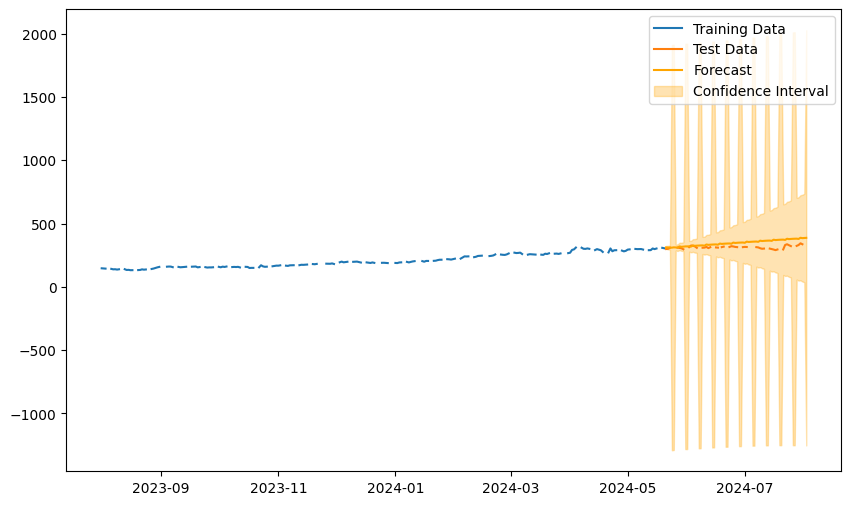

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='orange')
plt.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], color='orange', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.show()